In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

# Forward Problem Using Drift Diffusion Simulation

In [241]:
def simulate_diffusion(v, a, z, t0, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : float
        The drift rate (rate of information uptake)
    a     : float
        The boundary separation (decision threshold).
    z  : float in [0, 1]
        Relative starting point (prior option preferences)
    t0   : float
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = z * a
    num_steps = t0
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 3), c)


def simulate_diffusion_n(num_sims, v, a, z, t0, dt=1e-3, scale=1.0, max_time=10.):
    """Run a diffusion simmulation n times and return it in a numpy array."""

    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, z, t0, dt, scale, max_time)
    return data


def visualize_diffusion_model(data, label, figsize=(8, 6)):
    """Visualizes a diffusion model's results using the given data and label."""
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data[:, 0][data[:, 1] == 1], color='maroon', alpha=0.7, ax=ax, label='Correct responses')
    sns.histplot(data[:, 0][data[:, 1] == 0], color='gray', ax=ax, label='Incorrect responses')
    sns.despine(ax=ax)
    ax.set_title(label)
    ax.set_xlabel('Response time (s)', fontsize=18)
    ax.set_xticks(np.arange(0, 10))
    ax.set_yticks(np.arange(0, 90, 10))
    ax.set_ylabel('')
    ax.legend(fontsize=18)
    return f

In [242]:
params_speed = {
    'v': 0.5,       # drift rate
    'a': 1.5,       # boundary separation
    'z': 0.5,       # starting point
    't0': 0.5       # non decision time
}
params_accuracy = {
    'v': 0.5,       # drift rate
    'a': 3.5,       # boundary separation
    'z': 0.5,       # starting point
    't0': 0.5       # non decision time
}

In [243]:
# Simulate datasets for speed and accuracy prioritization
data_speed = simulate_diffusion_n(500, **params_speed)
data_accuracy = simulate_diffusion_n(500, **params_accuracy)

In [244]:
def visualize_frequencies(data):
  # Visualize the frequencies for each data set

  f, ax = plt.subplots(1, 1, figsize=(6, 4))
  print(data.shape)
  response, frequency = np.unique(data[:, 1], return_counts=True)
  sns.barplot(x=response.astype(np.int32), y=frequency, ax=ax, alpha=0.8, color='#00AA00')
  ax.set_xticklabels(["Incorrect", "Correct"])
  ax.set_xlabel('Response', fontsize=16)
  ax.set_ylabel('Frequency', fontsize=16)
  sns.despine(ax=ax)
  ax.grid(alpha=0.1, color='black')

  f.tight_layout()

(500, 2)


/tmp/ipykernel_3550/2955936000.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Incorrect", "Correct"])


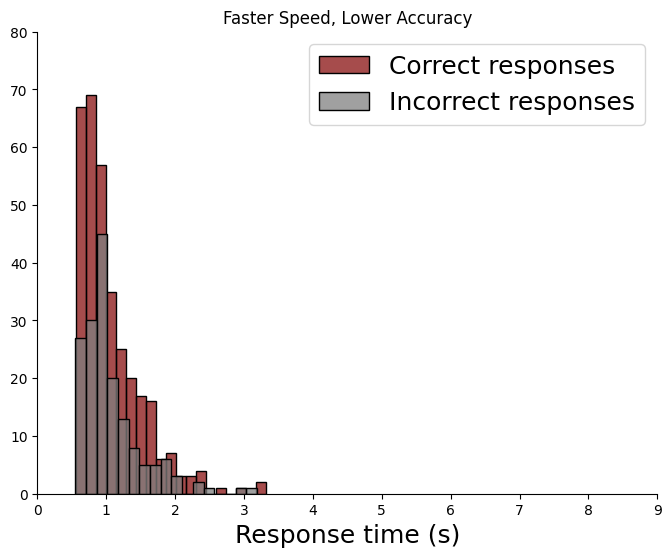

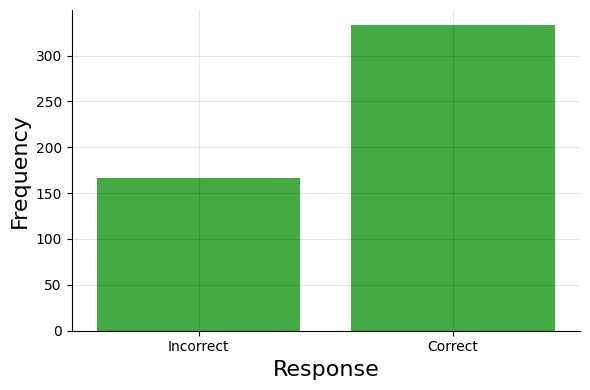

In [245]:
fs = visualize_diffusion_model(data_speed, "Faster Speed, Lower Accuracy")
visualize_frequencies(data_speed)

(500, 2)


/tmp/ipykernel_3550/2955936000.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Incorrect", "Correct"])


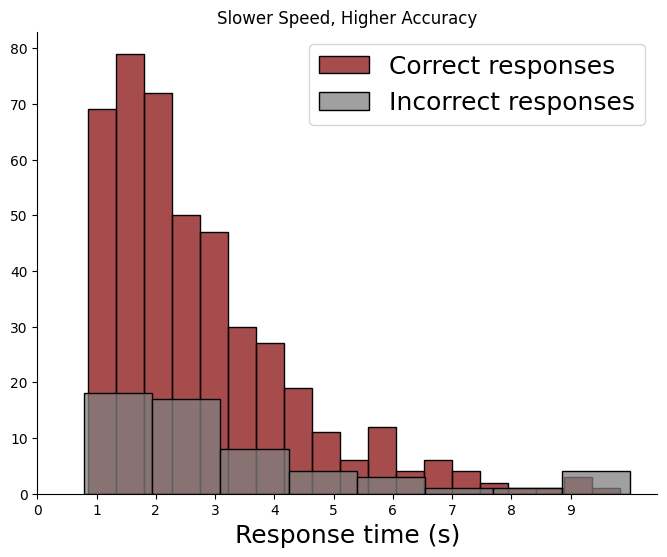

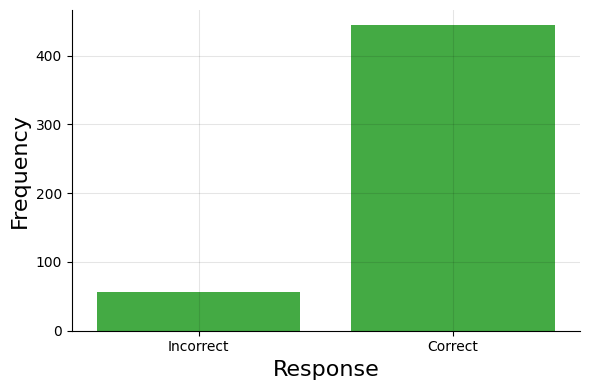

In [246]:
fa = visualize_diffusion_model(data_accuracy, "Slower Speed, Higher Accuracy")
visualize_frequencies(data_accuracy)

# Inverse Problem

In [247]:
stan_code = """

data {
    int<lower=1> N;
    vector[N] y;
    vector[N] c;
}

parameters {
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0, upper=1> z;
    real<lower=0> t0;
}

model {
    // Priors
    v ~ gamma(3, 1);
    a ~ gamma(3, 1);
    z ~ beta(2, 2);
    t0 ~ gamma(2, 1);

    // Likelihood (Wiener Model)
    for (n in 1:N) {
        if (c[n] == 1) {
            y[n] ~ wiener(a, t0, z, v);
        }
        else {
            y[n] ~ wiener(a, t0, 1-z, -v);
        }
    }
}
"""

In [248]:
# Prepare both speed and accuracy data for stan program
data_speed_dict = {
    'y': data_speed[:, 0], 
    'c': data_speed[:, 1].astype(int),
    'N': data_speed.shape[0]
}
data_accuracy_dict = {
    'y': data_accuracy[:, 0], 
    'c': data_accuracy[:, 1].astype(int),
    'N': data_accuracy.shape[0]
}

In [249]:
# Create speed stan model
diff_model_speed = stan.build(program_code=stan_code, data=data_speed_dict)

Building...

In file included from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/prim/prob/std_normal_ccdf_log.hpp:5,
                 from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/prim/prob.hpp:331,
                 from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/prim.hpp:16,
                 from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/rev.hpp:16,
                 from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/schild/.cache/httpstan/4.13.0/models/eid3nxli/model_eid3nxli.cpp:2:
/home/schild/anaconda3/envs/cognitive/lib/python3.12/site-packages/httpstan/include/stan/math/prim


Building: 14.3s, done.

In [250]:
# Create accuracy stan model
diff_model_accuracy = stan.build(program_code=stan_code, data=data_accuracy_dict)

Building...



Building: found in cache, done.

In [251]:
# Posterior inference using MCMC for speed prioritized data
fit_speed = diff_model_speed.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  28% (1700/6000)
Sampling:  47% (2800/6000)
Sampling:  65% (3900/6000)
Sampling:  85% (5100/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: wiener_lpdf: Random variable  = 0.993, but must be greater than nondecision time = 1.0111 (in '/tmp/httpstan_w1t7d0n_/model_eid3nxli.stan', line 26, column 12 to column 39)
  Gr

In [252]:
# Posterior inference using MCMC for accuracy prioritized data
fit_accuracy = diff_model_accuracy.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1601/6000)
Sampling:  28% (1702/6000)
Sampling:  47% (2802/6000)
Sampling:  63% (3802/6000)
Sampling:  80% (4801/6000)
Sampling:  97% (5800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: wiener_lpdf: Random variable  = 0.999, but must be greater than nondecision time = 1.0111 (in '/tmp/httpstan_w1t7d0n_/mod

In [262]:
# Posterior summary statistics for speed
print("Summary Statistics for Speed Prioritized Simulated Data (simulated boundary separation of 1.5)")
az.summary(fit_speed)

Summary Statistics for Speed Prioritized Simulated Data (simulated boundary separation of 1.5)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.540,0.033,1.477,1.602,0.001,0.000,3093.0,2853.0,1.0
t0,0.501,0.007,0.489,0.515,0.000,0.000,2802.0,2612.0,1.0
v,0.465,0.069,0.341,0.600,0.001,0.001,2689.0,2633.0,1.0
z,0.499,0.015,0.469,0.527,0.000,0.000,2842.0,2519.0,1.0


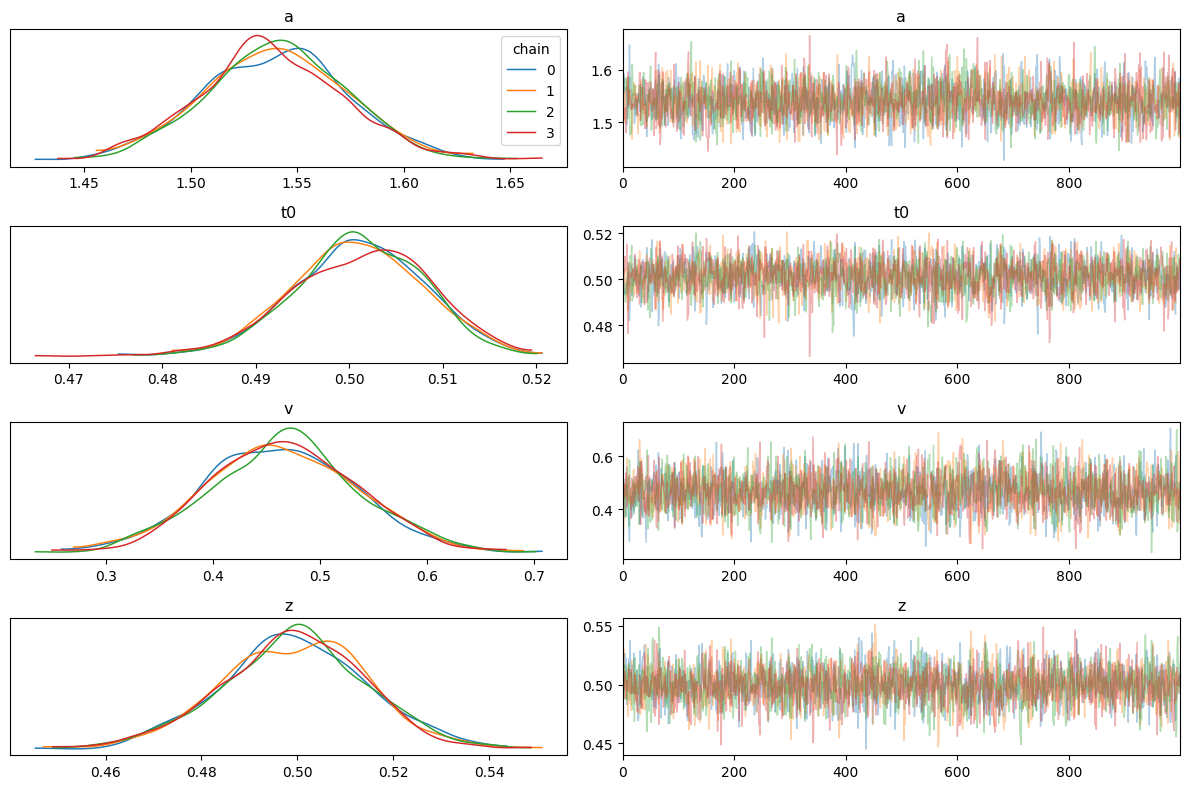

In [263]:
# Trace plots for speed prioritization
f = az.plot_trace(fit_speed, compact=False, legend=True)
plt.tight_layout()

In [264]:
# Posterior summary statistics for accuracy
print("Summary Statistics for Accuracy Prioritized Simulated Data (simulated boundary separation of 3.5)")
az.summary(fit_accuracy)

Summary Statistics for Accuracy Prioritized Simulated Data (simulated boundary separation of 3.5)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.483,0.093,3.311,3.661,0.002,0.001,1961.0,2343.0,1.0
t0,0.517,0.039,0.450,0.593,0.001,0.001,1878.0,1737.0,1.0
v,0.595,0.039,0.526,0.666,0.001,0.001,2238.0,2824.0,1.0
z,0.498,0.018,0.463,0.529,0.000,0.000,2198.0,2290.0,1.0


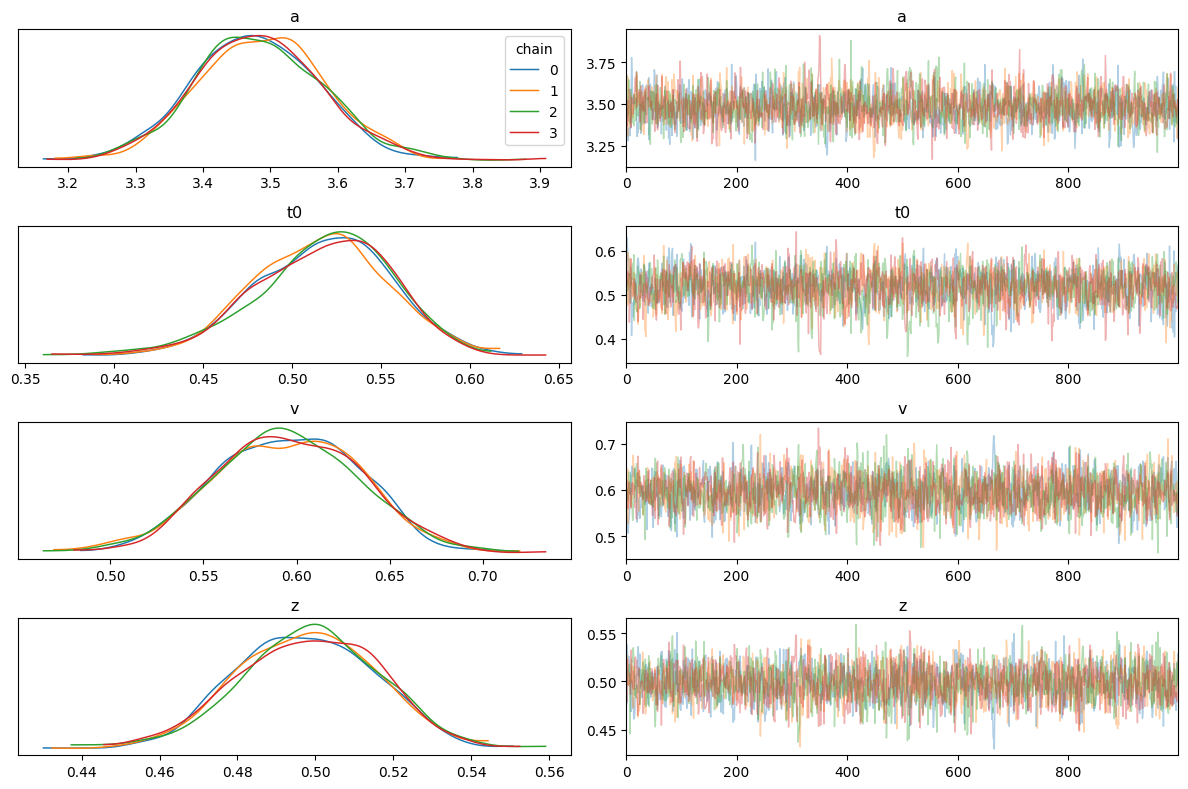

In [265]:
# Trace plots for accuracy prioritization
f = az.plot_trace(fit_accuracy, compact=False, legend=True)
plt.tight_layout()